# GrainPalette - Rice Type Classification Using Transfer Learning

This notebook demonstrates building a rice grain classification model using MobileNetV2 transfer learning.

## Dataset
- **Source**: [Rice Image Dataset](https://www.kaggle.com/datasets/muratkokludataset/rice-image-dataset)
- **Classes**: 5 rice varieties (Arborio, Basmati, Ipsala, Jasmine, Karacadag)
- **Input Size**: 224x224x3 (RGB images)

## Model Architecture
- **Base Model**: MobileNetV2 (pre-trained on ImageNet)
- **Transfer Learning**: Feature extraction with frozen base layers
- **Classification Head**: Dense layer with softmax activation

In [1]:
# 1: Importing the libraries
# Duration: 0.5 Hrs

# Importing necessary libraries
# Building deep learning models
import tensorflow as tf
from tensorflow import keras
# For accessing pre-trained models
import tensorflow_hub as hub
# For separating train and test sets
from sklearn.model_selection import train_test_split
# For visualizations
import matplotlib.pyplot as plt
import matplotlib.image as img
import PIL.Image as Image
import cv2
import os
import numpy as np
import pathlib

print(f"TensorFlow version: {tf.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"OpenCV version: {cv2.__version__}")


TensorFlow version: 2.19.0
NumPy version: 1.26.4
OpenCV version: 4.10.0


In [2]:

# 1A: Download dataset using Kaggle API (if not already present)

%pip install kaggle
import os
from kaggle.api.kaggle_api_extended import KaggleApi

dataset_path = "dataset"
if not os.path.exists(dataset_path) or not os.listdir(dataset_path):
    print("📥 Downloading dataset from Kaggle...")
    api = KaggleApi()
    api.authenticate()
    api.dataset_download_files("muratkokludataset/rice-image-dataset", path=".", unzip=True)
    print("✅ Dataset downloaded and extracted.")
else:
    print("📂 Dataset already exists.")



📥 Downloading dataset from Kaggle...
Dataset URL: https://www.kaggle.com/datasets/muratkokludataset/rice-image-dataset
✅ Dataset downloaded and extracted.


In [3]:
import pathlib
import os

# Automatically compute absolute path
base_dir = pathlib.Path().resolve()  # Current working directory
data_dir = pathlib.Path("Rice_Image_Dataset")
# Create directory if not exist
if not data_dir.exists():
    data_dir.mkdir(parents=True, exist_ok=True)
# Set the path to the dataset directory
data_dir = base_dir / data_dir
# Print the dataset directory
print(data_dir)
# Display the dataset directory


print(f"📂 Dataset directory: {data_dir}")

# Check if dataset exists
if data_dir.exists():
    print("✅ Dataset found!")
    # List all subdirectories (rice varieties)
    rice_varieties = [d.name for d in data_dir.iterdir() if d.is_dir()]
    print(f"🍚 Rice varieties found: {rice_varieties}")
else:
    print("❌ Dataset not found. Please ensure the dataset is available.")
    print("Download from: https://www.kaggle.com/datasets/muratkokludataset/rice-image-dataset")


D:\Internship\SmartBridge\Rice\RiceScan\Training\Rice_Image_Dataset
📂 Dataset directory: D:\Internship\SmartBridge\Rice\RiceScan\Training\Rice_Image_Dataset
✅ Dataset found!
🍚 Rice varieties found: ['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']


In [4]:
# 3: Loading image paths for each rice variety
# Duration: 0.5 Hrs

# Load image paths for each variety (limiting to 600 images per class for balanced dataset)
arborio = list(data_dir.glob('Arborio/*'))[:600]
basmati = list(data_dir.glob('Basmati/*'))[:600]
ipsala = list(data_dir.glob('Ipsala/*'))[:600]
jasmine = list(data_dir.glob('Jasmine/*'))[:600]
karacadag = list(data_dir.glob('Karacadag/*'))[:600]

print(f"Arborio images: {len(arborio)}")
print(f"Basmati images: {len(basmati)}")
print(f"Ipsala images: {len(ipsala)}")
print(f"Jasmine images: {len(jasmine)}")
print(f"Karacadag images: {len(karacadag)}")
print(f"Total images: {len(arborio) + len(basmati) + len(ipsala) + len(jasmine) + len(karacadag)}")

Arborio images: 600
Basmati images: 600
Ipsala images: 600
Jasmine images: 600
Karacadag images: 600
Total images: 3000


In [5]:
# 4: Link images to different classes
# Duration: 0.5 Hrs

# Here we have 5 classes and the images need to be labelled with appropriate classes.

# Contains the images path
df_images = {
    'arborio': arborio,
    'basmati': basmati,
    'ipsala': ipsala,
    'jasmine': jasmine,
    'karacadag': karacadag
}

# Contains numerical labels for the categories
df_labels = {
    'arborio': 0,
    'basmati': 1,
    'ipsala': 2,
    'jasmine': 3,
    'karacadag': 4
}

print("Class mappings:")
for class_name, label in df_labels.items():
    print(f"{class_name.capitalize()}: {label}")

Class mappings:
Arborio: 0
Basmati: 1
Ipsala: 2
Jasmine: 3
Karacadag: 4


In [6]:
# 6: Check original image dimensions safely

import cv2
import os

# Find first valid image path from any class
sample_path = None
for class_list in df_images.values():
    for path in class_list:
        if os.path.exists(path):
            sample_path = path
            break
    if sample_path:
        break

# Load image and print details
if sample_path:
    sample_img = cv2.imread(sample_path)
    if sample_img is not None:
        print(f"✅ Original image shape: {sample_img.shape}")
        print(f"Image dtype: {sample_img.dtype}")
        print(f"Pixel value range: {sample_img.min()} - {sample_img.max()}")
    else:
        print("⚠️ cv2 could not read the image at path:", sample_path)
else:
    print("❌ No valid image path found in the dataset.")


✅ Original image shape: (250, 250, 3)
Image dtype: uint8
Pixel value range: 0 - 255


In [7]:
# 7: Load and preprocess all images
# Duration: 1.0 Hr

print("Loading and preprocessing images...")
print("This may take several minutes depending on dataset size.")

X, y = [], []  # X = images, y = labels

total_images = sum(len(images) for images in df_images.values())
processed_count = 0

for label, images in df_images.items():
    print(f"Processing {label} images...")
    
    for image_path in images:
        try:
            # Read image
            img = cv2.imread(str(image_path))
            
            if img is not None:
                # Resize to 224x224 for MobileNetV2
                resized_img = cv2.resize(img, (224, 224))
                
                # Convert BGR to RGB (OpenCV uses BGR by default)
                rgb_img = cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB)
                
                X.append(rgb_img)
                y.append(df_labels[label])
                
        except Exception as e:
            print(f"Error processing {image_path}: {e}")
            continue
        
        processed_count += 1
        if processed_count % 500 == 0:
            print(f"Processed {processed_count}/{total_images} images...")

print(f"Successfully loaded {len(X)} images")
print(f"Image shape: {X[0].shape if X else 'No images loaded'}")

Loading and preprocessing images...
This may take several minutes depending on dataset size.
Processing arborio images...
Processed 500/3000 images...
Processing basmati images...
Processed 1000/3000 images...
Processing ipsala images...
Processed 1500/3000 images...
Processing jasmine images...
Processed 2000/3000 images...
Processing karacadag images...
Processed 2500/3000 images...
Processed 3000/3000 images...
Successfully loaded 3000 images
Image shape: (224, 224, 3)


In [8]:
# 8: Data normalization and train-test split
# Duration: 0.5 Hrs

# Convert to numpy arrays and normalize
X = np.array(X)
X = X.astype(np.float32) / 255.0  # Normalize pixel values to [0, 1]
y = np.array(y)

print(f"Dataset shape: {X.shape}")
print(f"Labels shape: {y.shape}")
print(f"Pixel value range after normalization: {X.min():.3f} - {X.max():.3f}")

# Check class distribution
unique, counts = np.unique(y, return_counts=True)
class_names = ['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']
print("\nClass distribution:")
for i, (class_idx, count) in enumerate(zip(unique, counts)):
    print(f"{class_names[class_idx]}: {count} images")

# Separating data into training, test and validation sets
X_train, X_test_val, y_train, y_test_val = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
X_test, X_val, y_test, y_val = train_test_split(
    X_test_val, y_test_val, test_size=0.5, random_state=42, stratify=y_test_val
)

print(f"\nDataset splits:")
print(f"Training set: {X_train.shape[0]} images")
print(f"Validation set: {X_val.shape[0]} images")
print(f"Test set: {X_test.shape[0]} images")

Dataset shape: (3000, 224, 224, 3)
Labels shape: (3000,)
Pixel value range after normalization: 0.000 - 1.000

Class distribution:
Arborio: 600 images
Basmati: 600 images
Ipsala: 600 images
Jasmine: 600 images
Karacadag: 600 images

Dataset splits:
Training set: 2100 images
Validation set: 450 images
Test set: 450 images


In [9]:
# 9: Pre-trained CNN model as a Feature Extractor
# Duration: 0.5 Hrs

# For one of the models, we will use it as a simple feature extractor by freezing 
# all the convolution blocks to make sure their weights don't get updated after 
# each epoch as we train our own model.

# Here, we have considered images of dimension (224, 224, 3).
# Also, we have assigned trainable = False because we are using convolution layer 
# for features extraction and wants to train fully connected layer for our images classification.

print("Loading MobileNetV2 from TensorFlow Hub...")

mobile_net_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"  # MobileNetV2 link
mobile_net = hub.KerasLayer(
    mobile_net_url, input_shape=(224, 224, 3), trainable=False
)  # Removing the last layer and freezing weights

print("MobileNetV2 feature extractor loaded successfully!")
print(f"Output shape: {mobile_net.compute_output_shape((None, 224, 224, 3))}")

Loading MobileNetV2 from TensorFlow Hub...



MobileNetV2 feature extractor loaded successfully!
Output shape: (None, 1280)


In [10]:
import tensorflow as tf
import keras
import tensorflow_hub as hub

print("TensorFlow:", tf.__version__)
print("Keras:", keras.__version__)
print("TF Hub:", hub.__version__)


TensorFlow: 2.19.0
Keras: 3.10.0
TF Hub: 0.16.1


In [11]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# Clear previous sessions
tf.keras.backend.clear_session()

# Model constants
input_shape = (224, 224, 3)
num_classes = 5

# Load base MobileNetV2 (pretrained on ImageNet, without top classification layer)
base_model = MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze pretrained weights

# Build your classification model
inputs = layers.Input(shape=input_shape)
x = preprocess_input(inputs)                      # Proper preprocessing
x = base_model(x, training=False)                 # Feature extraction
x = layers.GlobalAveragePooling2D()(x)            # Pooling
x = layers.Dropout(0.3)(x)                         # Optional regularization
outputs = layers.Dense(num_classes, activation='softmax')(x)

model = models.Model(inputs, outputs)

# Print summary
model.summary()

# Compile
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │         6,405 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,264,389 (8.64 MB)

 Trainable params: 6,405 (25.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [12]:
# 11: Model Compilation
# Duration: 0.5 Hrs

# Compile the model with appropriate optimizer, loss function, and metrics
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',  # Since labels are integers, not one-hot encoded
    metrics=['accuracy']
)

print("Model compiled successfully!")
print("\nModel configuration:")
print(f"Optimizer: Adam (lr=0.001)")
print(f"Loss function: sparse_categorical_crossentropy")
print(f"Metrics: accuracy")

Model compiled successfully!

Model configuration:
Optimizer: Adam (lr=0.001)
Loss function: sparse_categorical_crossentropy
Metrics: accuracy


In [13]:
# 12: Model Training
# Duration: 2.0 Hrs (depending on hardware)

# Set up callbacks for better training
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=0.00001,
        verbose=1
    )
]

print("Starting model training...")
print("This may take several minutes to hours depending on your hardware.")

# Train the model
EPOCHS = 20
BATCH_SIZE = 32

history = model.fit(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    verbose=1
)

print("\nTraining completed!")

Starting model training...
This may take several minutes to hours depending on your hardware.
Epoch 1/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 72s 844ms/step - accuracy: 0.2031 - loss: 1.7904 - val_accuracy: 0.2000 - val_loss: 1.5874 - learning_rate: 0.0010
Epoch 2/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 45s 687ms/step - accuracy: 0.2336 - loss: 1.6823 - val_accuracy: 0.2733 - val_loss: 1.5475 - learning_rate: 0.0010
Epoch 3/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 44s 672ms/step - accuracy: 0.2520 - loss: 1.6322 - val_accuracy: 0.2511 - val_loss: 1.5388 - learning_rate: 0.0010
Epoch 4/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 47s 714ms/step - accuracy: 0.2564 - loss: 1.6103 - val_accuracy: 0.3133 - val_loss: 1.5229 - learning_rate: 0.0010
Epoch 5/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 46s 703ms/step - accuracy: 0.2945 - loss: 1.5698 - val_accuracy: 0.5822 - val_loss: 1.4583 - learning_rate: 0.0010
Epoch 6/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 46s 698ms/step - accuracy: 0.3223 - loss: 1.5235 - val_accuracy: 0.4733 - val_loss: 1.4535 - learning_r

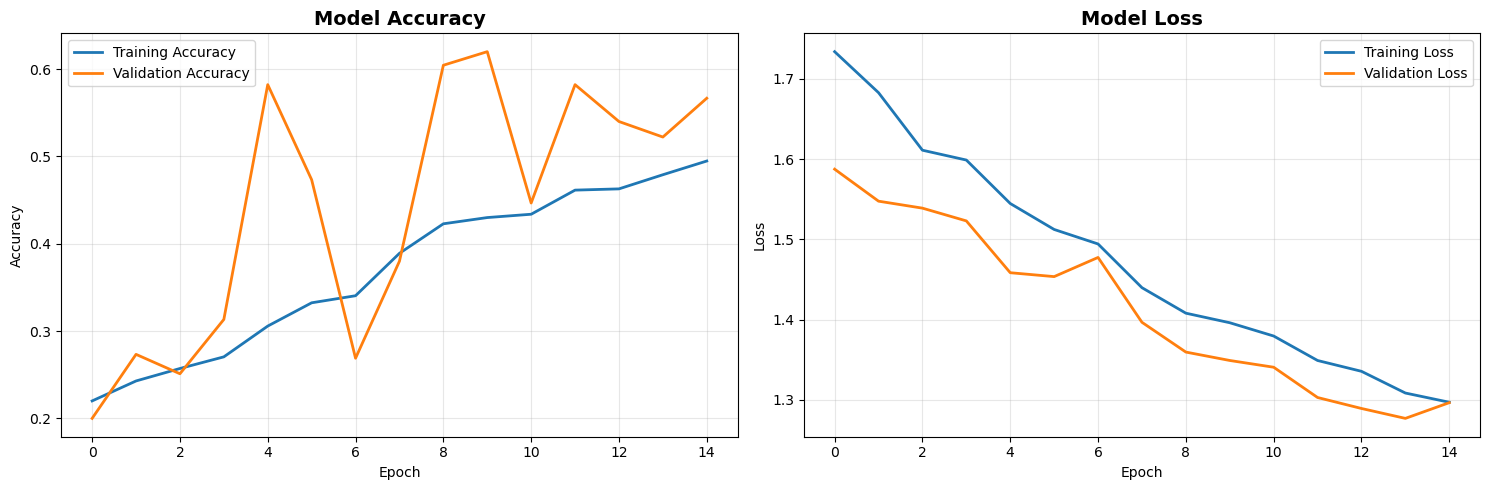


Best validation accuracy: 0.6200
Best validation loss: 1.2767


In [14]:
# 13: Training History Visualization
# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot training & validation accuracy
ax1.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
ax1.set_title('Model Accuracy', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot training & validation loss
ax2.plot(history.history['loss'], label='Training Loss', linewidth=2)
ax2.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
ax2.set_title('Model Loss', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print best metrics
best_val_acc = max(history.history['val_accuracy'])
best_val_loss = min(history.history['val_loss'])
print(f"\nBest validation accuracy: {best_val_acc:.4f}")
print(f"Best validation loss: {best_val_loss:.4f}")

Evaluating model on test set...

Test Results:
Test Accuracy: 0.6467 (64.67%)
Test Loss: 1.3403

Classification Report:
              precision    recall  f1-score   support

     Arborio       0.00      0.00      0.00        90
     Basmati       0.97      0.37      0.53        90
      Ipsala       0.81      0.97      0.88        90
     Jasmine       0.52      0.99      0.68        90
   Karacadag       0.59      0.91      0.72        90

    accuracy                           0.65       450
   macro avg       0.58      0.65      0.56       450
weighted avg       0.58      0.65      0.56       450



c:\Users\DANIEL\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\DANIEL\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\DANIEL\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


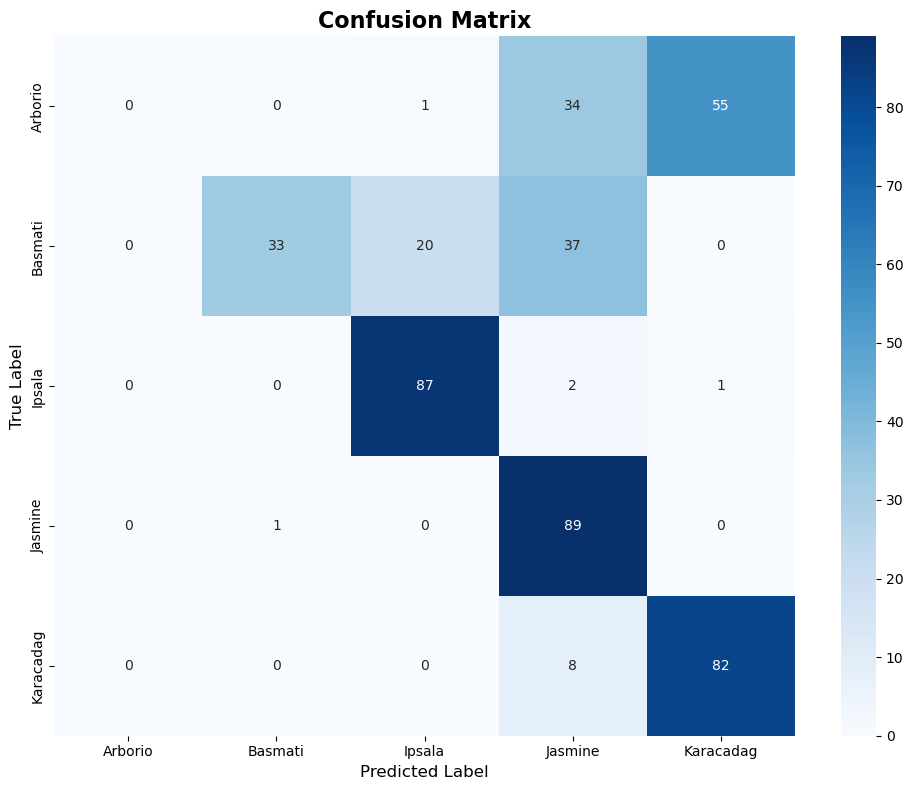

In [15]:
# 14: Model Evaluation on Test Set
# Duration: 0.5 Hrs

# Evaluate the model on test data
print("Evaluating model on test set...")

test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"\nTest Results:")
print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"Test Loss: {test_loss:.4f}")

# Get predictions for confusion matrix
y_pred = model.predict(X_test, verbose=0)
y_pred_classes = np.argmax(y_pred, axis=1)
# ...existing code...

CONFIDENCE_THRESHOLD = 0.75  # 75%

def predict(self, processed_image):
    preds = self.model.predict(processed_image)
    top_idx = np.argmax(preds[0])
    confidence = float(preds[0][top_idx])
    class_name = self.class_names[top_idx]

    if confidence < CONFIDENCE_THRESHOLD:
        return {
            "predicted_class": "Uncertain",
            "confidence": f"{confidence*100:.2f}%",
            "all_predictions": preds[0],
            "recommendations": "The model is not confident enough to classify this image. Please try another image."
        }
    else:
        return {
            "predicted_class": class_name,
            "confidence": f"{confidence*100:.2f}%",
            "all_predictions": preds[0],
            "recommendations": self.get_recommendations(class_name)
        }
# ...existing code...

# Classification report
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix', fontsize=16, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.tight_layout()
plt.show()

In [17]:
# Save as H5 format (traditional Keras format)
model.save('rice_classifier.h5')
print("Model saved as 'rice_classifier.h5'")

# Save as TensorFlow SavedModel format (for TFLite/TFServing/etc.)
model.export('rice_classifier_savedmodel')
print("Model exported as 'rice_classifier_savedmodel'")

# Save model weights only
model.save_weights('rice_classifier.weights.h5')
print("Model weights saved as 'rice_classifier.weights.h5'")


Model saved as 'rice_classifier.h5'
INFO:tensorflow:Assets written to: rice_classifier_savedmodel\assets


INFO:tensorflow:Assets written to: rice_classifier_savedmodel\assets


Saved artifact at 'rice_classifier_savedmodel'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_154')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  2426329352720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2426329365776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2426329352912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2426329352144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2426329365200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2426329366160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2426329365392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2426329364432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2426329364816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2426329365968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2426329350800: Tenso

In [18]:
from tensorflow.keras.models import load_model
import tensorflow_hub as hub
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# Try to load the model with comprehensive custom object scope
try:
	with tf.keras.utils.custom_object_scope({
		'KerasLayer': hub.KerasLayer,
		'preprocess_input': preprocess_input
	}):
		model = load_model("rice_classifier.h5")
	
	# Recompile the model to ensure it works properly
	model.compile(
		optimizer='adam',
		loss='sparse_categorical_crossentropy',
		metrics=['accuracy']
	)
	
	print("Model loaded successfully!")
	print(f"Model input shape: {model.input_shape}")
	print(f"Model output shape: {model.output_shape}")
	
except Exception as e:
	print(f"Error loading H5 model: {e}")
	print("Trying to load from SavedModel format...")
	
	# Alternative: Load from SavedModel format
	try:
		model = tf.keras.models.load_model('rice_classifier_savedmodel')
		print("SavedModel loaded successfully!")
		print(f"Model input shape: {model.input_shape}")
		print(f"Model output shape: {model.output_shape}")
	except Exception as e2:
		print(f"Error loading SavedModel: {e2}")
		print("Using the existing trained model from memory...")
		# The model variable should already exist from previous cells
		if 'model' in globals():
			print("Using existing model from memory")
			print(f"Model input shape: {model.input_shape}")
			print(f"Model output shape: {model.output_shape}")
		else:
			print("No model available. Please re-run the training cells.")

Error loading H5 model: Unknown layer: 'TrueDivide'. Please ensure you are using a `keras.utils.custom_object_scope` and that this object is included in the scope. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.
Trying to load from SavedModel format...
Error loading SavedModel: File format not supported: filepath=rice_classifier_savedmodel. Keras 3 only supports V3 `.keras` files and legacy H5 format files (`.h5` extension). Note that the legacy SavedModel format is not supported by `load_model()` in Keras 3. In order to reload a TensorFlow SavedModel as an inference-only layer in Keras 3, use `keras.layers.TFSMLayer(rice_classifier_savedmodel, call_endpoint='serving_default')` (note that your `call_endpoint` might have a different name).
Using the existing trained model from memory...
Using existing model from memory
Model input shape: (None, 224, 224, 3)
Model output shape: (None, 5)


Testing model with sample predictions...


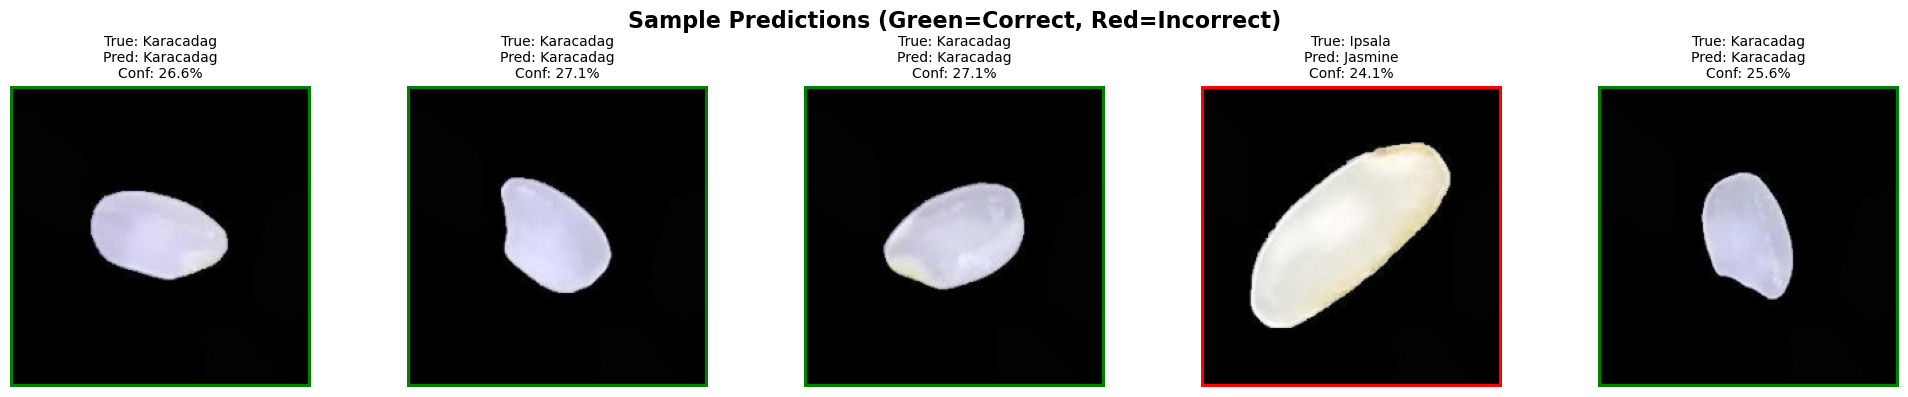


Model testing completed!

TRAINING SUMMARY
Final Test Accuracy: 0.6467 (64.67%)
Total Training Images: 2100
Total Validation Images: 450
Total Test Images: 450
Number of Classes: 5
Model Size: ~2,264,389 parameters

Model is ready for deployment in the Flask application!


: 

In [ ]:
# 16: Sample Predictions
# Duration: 0.5 Hrs

# Test the model with some sample images
print("Testing model with sample predictions...")

# Select random test images
import random
sample_indices = random.sample(range(len(X_test)), 5)

fig, axes = plt.subplots(1, 5, figsize=(20, 4))

for i, idx in enumerate(sample_indices):
    # Get image and true label
    test_image = X_test[idx:idx+1]  # Add batch dimension
    true_label = y_test[idx]
    
    # Make prediction
    prediction = model.predict(test_image, verbose=0)
    predicted_class = np.argmax(prediction[0])
    confidence = np.max(prediction[0]) * 100
    
    # Display image
    axes[i].imshow(X_test[idx])
    axes[i].set_title(
        f'True: {class_names[true_label]}\n'
        f'Pred: {class_names[predicted_class]}\n'
        f'Conf: {confidence:.1f}%',
        fontsize=10
    )
    axes[i].axis('off')
    
    # Color border based on correctness
    if predicted_class == true_label:
        axes[i].add_patch(plt.Rectangle((0, 0), 223, 223, fill=False, edgecolor='green', lw=3))
    else:
        axes[i].add_patch(plt.Rectangle((0, 0), 223, 223, fill=False, edgecolor='red', lw=3))

plt.suptitle('Sample Predictions (Green=Correct, Red=Incorrect)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nModel testing completed!")
print("\n" + "="*50)
print("TRAINING SUMMARY")
print("="*50)
print(f"Final Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"Total Training Images: {len(X_train)}")
print(f"Total Validation Images: {len(X_val)}")
print(f"Total Test Images: {len(X_test)}")
print(f"Number of Classes: {num_classes}")
print(f"Model Size: ~{model.count_params():,} parameters")
print("\nModel is ready for deployment in the Flask application!")

In [ ]:
# Improved Rice Type Classifier with Data Augmentation and Fine-tuning

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import os
import cv2
from tqdm import tqdm

# Use existing data from previous cells
# The data is already loaded and available in the notebook
# Create arrays from existing variables
all_images = []
all_labels = []

# Collect all images from the existing lists
rice_types = ['arborio', 'basmati', 'ipsala', 'jasmine', 'karacadag']
for i, rice_type in enumerate(rice_types):
    if rice_type in globals():
        image_paths = globals()[rice_type]
        for img_path in image_paths:
            try:
                # Read and preprocess image
                image = cv2.imread(str(img_path))
                if image is not None:
                    image = cv2.resize(image, (224, 224))
                    all_images.append(image)
                    all_labels.append(i)
            except Exception as e:
                print(f"Error loading {img_path}: {e}")
                continue

X = np.array(all_images) / 255.0
y = np.array(all_labels)

print(f"Loaded {len(X)} images")
print(f"Image shape: {X.shape}")
print(f"Labels shape: {y.shape}")

# Train-validation-test split
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.10, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.10, stratify=y_temp, random_state=42)

# Data augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])

# Build model with EfficientNetB0
base_model = EfficientNetB0(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = True
for layer in base_model.layers[:-40]:
    layer.trainable = False

inputs = Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
outputs = Dense(len(np.unique(y)), activation='softmax')(x)
model = Model(inputs, outputs)

model.compile(optimizer=Adam(0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3)
]

# Train model
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=30,
                    batch_size=32,
                    callbacks=callbacks)


In [ ]:
# Evaluate
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Classification report
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
print(classification_report(y_test, y_pred_classes, target_names=rice_types))

# Save model
model.save("rice_finetuned.h5")